In [2]:
%pylab inline

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from cartopy.io import PostprocessedRasterSource, LocatedImage
from cartopy.io import srtm
from cartopy.io.srtm import SRTM3Source
import cartopy.feature as cfeature

from osgeo import gdal
from osgeo import gdal_array

import scipy.ndimage
import scipy.misc



Populating the interactive namespace from numpy and matplotlib


In [3]:
base_projection     = ccrs.PlateCarree() 
global_extent     = [-180.0, 180.0, -90.0, 90.0]

etopo1       = gdal.Open("Resources/color_etopo1_ice_low.tif")
etopo_img    = etopo1.ReadAsArray().transpose(1,2,0)

globalrelief      = gdal.Open("Resources/HYP_50M_SR_W.tif")
globalrelief_img  = globalrelief.ReadAsArray().transpose(1,2,0)

globalbathym      = gdal.Open("Resources/OB_50M.tif")
globalbathym_img  = globalbathym.ReadAsArray().transpose(1,2,0)

global_shrelief = gdal.Open("/Users/lmoresi/+Github/teaching-python/Mapping/Resources/etopo1_grayscale_hillshade.tif")
global_shrelief_img = global_shrelief.ReadAsArray()[::2,::2] / 256.0

# Height field only ... 
etopoH = gdal.Open("Resources/ETOPO_c_geotiff_10800.tif") 
etopoH_img = etopoH.ReadAsArray()

strainrate_extent=[-180,180,-68,80]
strainrate = numpy.loadtxt("/Users/lmoresi/+Github/teaching-python/Mapping/Resources/sec_invariant_strain_0.2.dat")
strainrate_data = strainrate.reshape(741,1800,3)  # I had to look at the data to work this out !
strainrate_img  = strainrate_data[:,:,2]


In [4]:
print etopo_img.shape
print globalrelief_img.shape
print etopoH_img.shape
print global_shrelief_img.shape

(2700, 5400, 3)
(5400, 10800, 3)
(5400, 10800)
(5401, 10801)


In [5]:
blended_img = np.empty_like(globalrelief_img)
blended_img[...,0] = np.where( etopoH_img < 0.0, globalbathym_img[...,0], globalrelief_img[...,0] )
blended_img[...,1] = np.where( etopoH_img < 0.0, globalbathym_img[...,1], globalrelief_img[...,1] )
blended_img[...,2] = np.where( etopoH_img < 0.0, globalbathym_img[...,2], globalrelief_img[...,2] )

In [6]:
# img_heights  = etopo_img.reshape(-1)

base_projection = ccrs.PlateCarree()
global_extent = [ -180, 180, -90, 90 ]

coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m',
                           edgecolor=(0.0,0.0,0.0),
                           facecolor="none")

rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m',
                                        edgecolor='Blue', facecolor="none")

lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                        edgecolor="blue", facecolor="blue")

ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                           edgecolor="green",
                           facecolor="blue")

graticules_5 = cfeature.NaturalEarthFeature('physical', 'graticules_5', '10m',
                           edgecolor="black", facecolor=None)


In [7]:
from obspy.core import event
from obspy.fdsn import Client
from obspy import UTCDateTime

client = Client("IRIS")

himalaya_extent = [65, 110, 5, 45 ]

starttime = UTCDateTime("1965-01-01")
endtime   = UTCDateTime("2016-01-01")
cat = client.get_events(starttime=starttime, endtime=endtime,
                        minlongitude=himalaya_extent[0],
                        maxlongitude=himalaya_extent[1],
                        minlatitude=himalaya_extent[2],
                        maxlatitude=himalaya_extent[3],
                        minmagnitude=4.5, catalog="ISC")

print cat.count(), " events in catalogue"

30018  events in catalogue


In [8]:
event_count = cat.count()

eq_origins = np.zeros((event_count, 5))

for ev, event in enumerate(cat.events):
    eq_origins[ev,0] = dict(event.origins[0])['longitude']
    eq_origins[ev,1] = dict(event.origins[0])['latitude']
    eq_origins[ev,2] = dict(event.origins[0])['depth']
    eq_origins[ev,3] = dict(event.magnitudes[0])['mag']
    eq_origins[ev,4] = (dict(event.origins[0])['time']).date.year



In [88]:
from netCDF4 import Dataset

# rootgrp = Dataset("Resources/velocity_EU.nc", "r", format="NETCDF4")

rootgrp = Dataset("Resources/velocity_EU.nc", "r", format="NETCDF4")

ve = rootgrp.variables["ve"]
vn = rootgrp.variables["vn"]

lonv = rootgrp.variables["lon"]
latv = rootgrp.variables["lat"]

lons = lonv[::1]
lats = latv[::1]
llX, llY = np.meshgrid(lons,lats)

#llX = llX.reshape(-1)
#llY = llY.reshape(-1)

Veast = (np.array(ve[::1,::1]).T)
Vnorth = (np.array(vn[::1,::1]).T)

Vorientation = np.arctan2(Vnorth,Veast)
Vspeed = np.sqrt(Veast**2 + Vnorth**2)


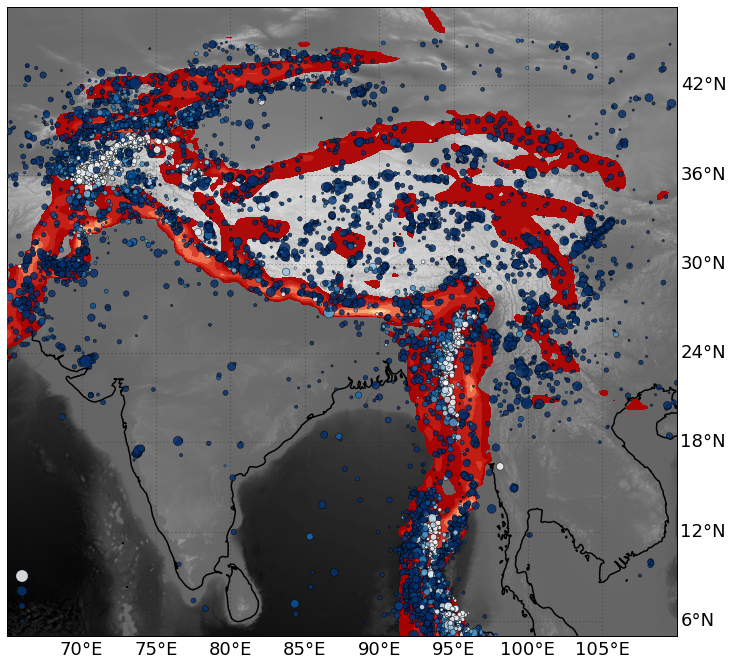

In [113]:
import gdal
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker


fig = plt.figure(figsize=(12, 12), facecolor="none")
ax = plt.axes(projection=ccrs.PlateCarree(), extent=himalaya_extent)

etopoH_img2 = (etopoH_img - etopoH_img.min()) / (etopoH_img.max() - etopoH_img.min())

ax.imshow(etopoH_img, transform=ccrs.PlateCarree(), origin="upper", 
           alpha=1.0, extent=global_extent, interpolation="spline16", vmin=-5000, vmax=7500,
           cmap=cm.gray, zorder=1)



mappable2 = ax.contourf(strainrate_data[:,:,0], strainrate_data[:,:,1], strainrate_data[:,:,2], 
         levels=[ 25, 50, 75 , 100, 150, 200, 250, 300 ], linestyle=None, vmin=5.0, vmax=300,
         transform=base_projection,  cmap=cm.OrRd_r, alpha=0.95, linewidth=2.0,
         extent=strainrate_extent, extend="max", zorder=12)


# plt.colorbar(mappable=mappable2)

ax.add_feature(coastline, linewidth=1.5,  edgecolor="Black", zorder=10)
# ax.add_feature(rivers,    linewidth=1,    edgecolor="Blue", zorder=12)
# ax.add_feature(lakes,     linewidth=1,    edgecolor="Blue", zorder=13, alpha=0.25)
# ax.add_feature(graticules_5,     linewidth=0.5, linestyle=":",    edgecolor="gray", zorder=4, alpha=0.75)


# ax.add_feature(ocean, facecolor=(0.4,0.4,0.6), edgecolor=(0.0,0.0,0.0), linewidth=1, alpha=0.75, zorder=4)

depth_scale = ax.scatter(eq_origins[:,0], eq_origins[:,1], 50.0*(eq_origins[:,3]-4.5), c=eq_origins[:,2], marker='o', 
               cmap=cm.Blues_r, vmin=35000, vmax=100000, alpha = 0.85, linewidth=0.5, zorder=20)


# plt.colorbar(mappable=depth_scale)


## Labels

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='#222222', alpha=1.0, linestyle=':' )

gl.xlabels_top = False
gl.ylabels_left = False
# gl.xlines = False
# gl.xlines = False


gl.xlocator = mticker.FixedLocator(np.arange(65,110,5))
glyxlocator = mticker.FixedLocator(np.arange(5,45,5))

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}


## Legendary stuff

mag4_color     = cm.Blues( 1.0 )
mag4_dot35km   = ax.scatter(66.0, 6.0, 50.0*(4.6-4.5), marker='o', color=mag4_color,
                 vmin=30000, vmax=100000, alpha = 0.85, linewidth=0.5, zorder=21)

mag5_color     = cm.Blues( 1.0- (50 - 30) / 70 )
mag5_dot50km   = ax.scatter(66.0, 7.0, 50.0*(5.0-4.5), marker='o', color=mag5_color,
                 vmin=30000, vmax=100000, alpha = 0.85, linewidth=0.5, zorder=21)

mag6_color     = cm.Blues(1.0- (70 - 30) / 70 )
mag6_dot70km   = ax.scatter(66.0, 8.0, 50.0*(6.0-4.5), marker='o', color=mag6_color,
                 vmin=30000, vmax=100000, alpha = 0.85, linewidth=0.5, zorder=21)

mag7_color     = cm.Blues( 0.0 )
mag7_dot100km   = ax.scatter(66.0, 9.0, 50.0*(7.0-4.5), marker='o', color=mag7_color,
                 vmin=30000, vmax=100000, alpha = 0.85, linewidth=0.5, zorder=21)



# # # Put a white cross over some of the data.
# # white_cross, = plt.plot(z[:5], "w+", markeredgewidth=3, markersize=15)

# plt.legend([mag4_dot30km, mag5_dot50km, mag6_dot70km, mag7_dot100km], 
#            [" < 4; < 30km ", " 5 ;  50km ", " 6 ;  70km ", " 7 ; > 100km " ],  )



In [71]:
fig.savefig("HimalayaEQ.png", dpi=600)

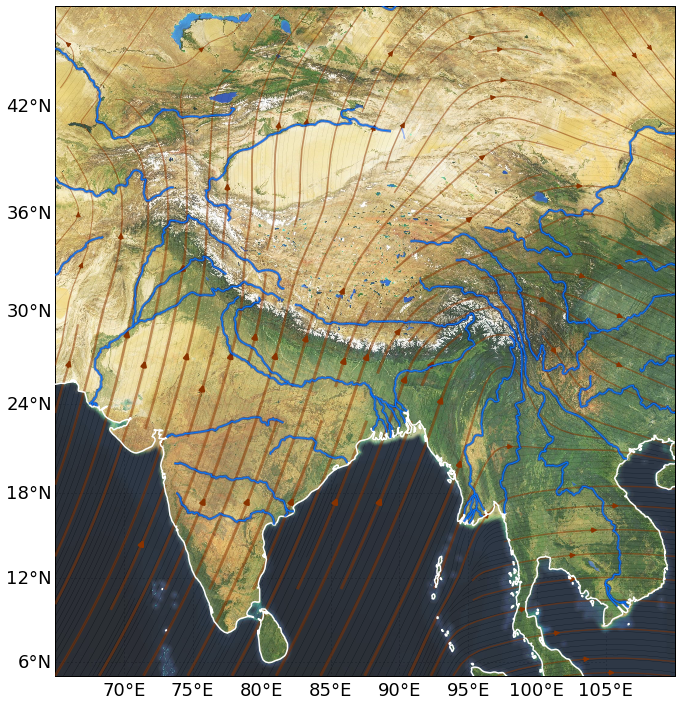

In [110]:
from matplotlib.transforms import offset_copy

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

# Map / Image Tile machinery

map_quest_aerial = cimgt.MapQuestOpenAerial()
mapbox_satellite = cimgt.MapboxTiles(map_id='mapbox.satellite', 
                                     access_token='pk.eyJ1IjoibG91aXNtb3Jlc2kiLCJhIjoiY2lnOXBuODFoMHNsYnY3bTE1M3czYjdrdyJ9.INMyf5g1FOIah75kOa2ZBg')
map_tiles = mapbox_satellite

fig = plt.figure(figsize=(12, 12), facecolor="none")
# ax = plt.axes(projection=ccrs.PlateCarree(), extent=himalaya_extent)

# Create a GeoAxes in the tile's projection.
ax = plt.axes(projection=map_tiles.crs)

    # Limit the extent of the map to a small longitude/latitude range.
ax.set_extent(himalaya_extent)

    # Add the MapQuest data at zoom level 8.
    
ax.streamplot(lons, lats, Veast, Vnorth, linewidth=0.25, color='black', 
              cmap=cm.gray_r, density=5.0, transform=ccrs.PlateCarree(), zorder=0, arrowstyle='-')

ax.add_image(map_tiles, 6, alpha=0.85, zorder=2)

streamlines = ax.streamplot(lons, lats, Veast, Vnorth, linewidth=1+Vspeed*0.05, color='#883300', cmap=cm.Reds_r,
              transform=ccrs.PlateCarree(), zorder=4)

streamlines.lines.set_alpha(0.5)


# ax.contour(strainrate_data[:,:,0], strainrate_data[:,:,1], strainrate_data[:,:,2], 
#          levels=[ 25, 50, 75 , 100, 150, 200, 250, 300 ], linestyle='solid', vmin=5.0, vmax=300,
#          transform=base_projection,  cmap=cm.OrRd_r, alpha=1.0, linewidth=2.0,
#          extent=strainrate_extent, extend="max", zorder=12)

# ax.contourf(strainrate_data[:,:,0], strainrate_data[:,:,1], strainrate_data[:,:,2], 
#          levels=[ 25, 50, 75 , 100, 150, 200, 250, 300 ], linestyle=None, vmin=5.0, vmax=300,
#          transform=base_projection,  cmap=cm.OrRd_r, alpha=0.25, linewidth=0.0,
#          extent=strainrate_extent, extend="max", zorder=12)


ax.add_feature(coastline, linewidth=1.5,  edgecolor="White", zorder=10)
ax.add_feature(rivers,    linewidth=1.0,    edgecolor="#0077FF", zorder=13)
ax.add_feature(rivers,    linewidth=3.0,    edgecolor="#002299",    zorder=12, alpha=0.5)
ax.add_feature(lakes,     linewidth=0,    edgecolor="Blue", facecolor="#4477FF", zorder=11, alpha=0.5)

# ax.quiver(llX, llY, Veast, Vnorth, Vorientation, scale=500, transform=ccrs.PlateCarree(),
#         cmap=cm.Blues, alpha=1.0, zorder=13, pivot="mid")


gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='#222222', alpha=1.0, linestyle=':' )

gl.xlabels_top = False
gl.ylabels_right = False
# gl.xlines = False
# gl.xlines = False


gl.xlocator = mticker.FixedLocator(np.arange(65,110,5))
glyxlocator = mticker.FixedLocator(np.arange(5,45,5))

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}


In [111]:
fig.savefig("HimalayaRivers.png", dpi=600)

In [ ]:
theCM = cm.get_cmap('Oranges')
theCM._init()

alphas = np.abs(np.linspace(0.0, 1.0, theCM.N))
theCM._lut[:-3,-1] = alphas**0.25

fig = plt.figure(figsize=(12, 12), facecolor="none")
ax = plt.axes(projection=ccrs.PlateCarree(), extent=himalaya_extent)
# plt.imshow(strainrate_img, cmap=theCM, origin="lower", interpolation="spline16", extent=strainrate_extent, 
#             vmin=-1, vmax=100)

etopoH_img2 = (etopoH_img - etopoH_img.min()) / (etopoH_img.max() - etopoH_img.min())

plt.imshow(etopo_img, transform=ccrs.PlateCarree(), extent=[-180,180,-90,90], alpha=0.5)


ax.contourf(strainrate_data[:,:,0], strainrate_data[:,:,1], strainrate_data[:,:,2], 
         levels=[20,30,40,50], linewidth=0.0, vmin=20.0, vmax=200,
         transform=base_projection,  cmap="YlOrRd", zorder=2, alpha=0.25, extent=strainrate_extent)

ax.contourf(strainrate_data[:,:,0], strainrate_data[:,:,1], strainrate_data[:,:,2], 
         levels=[60,70,80,90,100, 200], linewidth=0.0, vmin=20.0, vmax=200,
         transform=base_projection,  cmap="YlOrRd", zorder=2, alpha=0.5, extent=strainrate_extent)

ax.add_feature(coastline, linewidth=1.5,  edgecolor="Black", zorder=1)
ax.add_feature(rivers,    linewidth=1,    edgecolor="Blue", zorder=2)
ax.add_feature(lakes,     linewidth=1,    edgecolor="Blue", zorder=3, alpha=0.25)



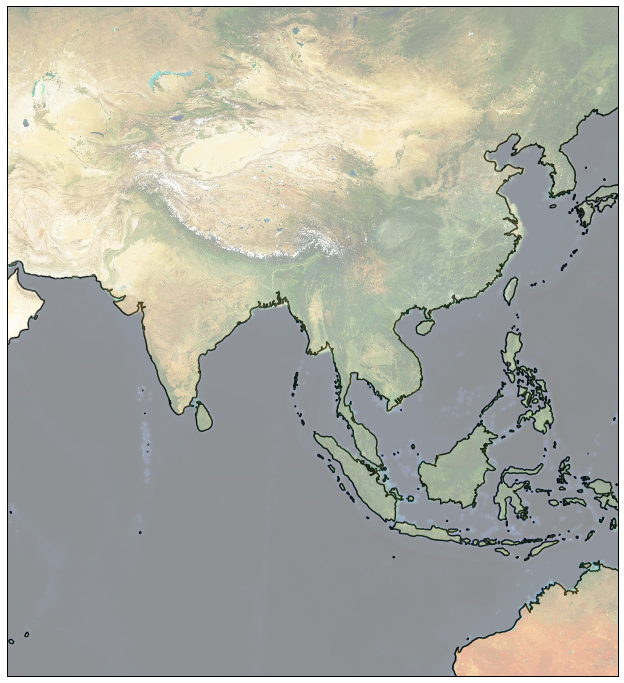

In [115]:
## Regional Setting


himalaya_region_extent = [ 55 , 135, -20, 45 ]

mapbox_satellite = cimgt.MapboxTiles(map_id='mapbox.satellite', 
        access_token='pk.eyJ1IjoibG91aXNtb3Jlc2kiLCJhIjoiY2lnOXBuODFoMHNsYnY3bTE1M3czYjdrdyJ9.INMyf5g1FOIah75kOa2ZBg')

map_tiles = mapbox_satellite

fig = plt.figure(figsize=(12, 12), facecolor="none")
# ax = plt.axes(projection=ccrs.PlateCarree(), extent=himalaya_extent)

# Create a GeoAxes in the tile's projection.
ax = plt.axes(projection=map_tiles.crs)

    # Limit the extent of the map to a small longitude/latitude range.
ax.set_extent(himalaya_region_extent)

ax.add_image(map_tiles, 5, alpha=0.45, zorder=2)

ax.add_feature(coastline, linewidth=1.5,  edgecolor="Black", zorder=1)




In [116]:
fig.savefig("HimalayaRegionalMap.png", dpi=600)

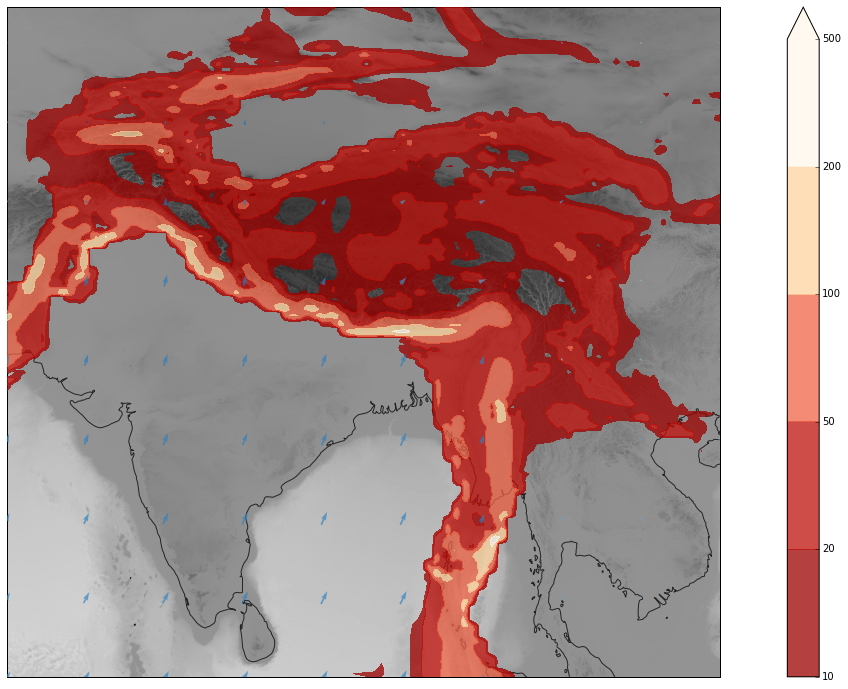

In [36]:
from netCDF4 import Dataset

# rootgrp = Dataset("Resources/velocity_EU.nc", "r", format="NETCDF4")

rootgrp = Dataset("Resources/velocity_EU.nc", "r", format="NETCDF4")

ve = rootgrp.variables["ve"]
vn = rootgrp.variables["vn"]

lonv = rootgrp.variables["lon"]
latv = rootgrp.variables["lat"]

lons = lonv[::5]
lats = latv[::5]
llX, llY = np.meshgrid(lons,lats)

#llX = llX.reshape(-1)
#llY = llY.reshape(-1)

Veast = (np.array(ve[::5,::5]).T)
Vnorth = (np.array(vn[::5,::5]).T)

Vorientation = np.arctan2(Vnorth,Veast)


#projection = ccrs.Orthographic(central_longitude=-150.0, central_latitude=60.0, globe=None)
#projection = ccrs.Orthographic(central_longitude=120.0, central_latitude=5.0, globe=None)
projection = ccrs.PlateCarree()
# projection = ccrs.Mollweide(central_longitude=120)
#projection = ccrs.Robinson(central_longitude=120)

fig = plt.figure(figsize=(24, 12), facecolor="none")

ax = plt.axes(projection=projection)

etopoH_img2 = (etopoH_img - etopoH_img.min()) / (etopoH_img.max() - etopoH_img.min())

ax.imshow(etopoH_img2**1.5, transform=ccrs.PlateCarree(), origin="upper", 
           alpha=1.0, extent=global_extent, interpolation="spline16", cmap=cm.gray_r, zorder=0)



# global_shrelief_img

# ax.contour(strainrate_data[:,:,0], strainrate_data[:,:,1], strainrate_data[:,:,2], 
#          levels=[50, 100, 200, 500], linestyle=None, vmin=49.0, vmax=1000,
#          transform=base_projection,  cmap="Oranges_r", zorder=2, alpha=0.75, extent=strainrate_extent)


mappable2 = ax.contourf(strainrate_data[:,:,0], strainrate_data[:,:,1], strainrate_data[:,:,2], 
         levels=[10, 20, 50, 100, 200, 500], linestyle=None, vmin=1.0, vmax=200,
         transform=base_projection,  cmap=cm.OrRd_r, alpha=0.75, 
         extent=strainrate_extent, extend="max", zorder=12)


plt.colorbar(mappable=mappable2)


mappable1 = ax.quiver(llX, llY, Veast, Vnorth, Vorientation, scale=2000, transform=ccrs.PlateCarree(),
        cmap=cm.Blues, alpha=0.7, zorder=13, pivot="mid")
#ax.streamplot(lons, lats, Veast, Vnorth, transform=ccrs.PlateCarree())


ax.add_feature(coastline, linewidth=1.0,  edgecolor="#000000", zorder=2, alpha=0.75)
# ax.add_feature(rivers,    linewidth=1,    edgecolor="Blue", zorder=2)
# ax.add_feature(lakes,     linewidth=1,    edgecolor="Blue", zorder=3, alpha=0.25)
# ax.add_feature(graticules_5, linewidth=0.25, edgecolor="black", linestyle=":", zorder=1, alpha=0.75)

ax.set_extent(himalaya_extent)



In [119]:
print Vspeed.max()
print Veast.max()
print Vnorth.max()


107.768
81.392
98.784


In [ ]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())

elev, crs, extent = srtm_composite(-120, 33, 4, 4)
elev = np.ma.masked_less_equal(elev, -100, copy=False)

plt.imshow(elev, extent=extent, transform=crs,
           cmap='terrain', origin='lower')
cb = plt.colorbar(orientation='vertical')
cb.set_label('Altitude')
plt.title("SRTM Map")
gl = ax.gridlines(draw_labels=True,)
gl.xlabels_top = False
gl.ylabels_left = False